<a href="https://colab.research.google.com/github/AbdullahNasser98/Tahaluf-project/blob/master/Task-2%20(Cloth%20classification)/clothing_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

There is a dataset of clothing containing over 5,000 images of 20 different classes. 
The full dataset can be found here: https://www.kaggle.com/datasets/agrigorev/clothing-dataset-full?select=images.csv

In this notebook we use a small subset of this data, consisting of the top 10 classes.

In [ ]:
# Download the dataset
!git clone https://github.com/alexeygrigorev/clothing-dataset-small.git

Cloning into 'clothing-dataset-small'...
remote: Enumerating objects: 3839, done.
remote: Counting objects: 100% (400/400), done.
remote: Compressing objects: 100% (400/400), done.
remote: Total 3839 (delta 9), reused 385 (delta 0), pack-reused 3439
Receiving objects: 100% (3839/3839), 100.58 MiB | 43.81 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [ ]:
import pandas as pd
import numpy as np
import cv2 as cv
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn

In [ ]:
train_dir = '/content/clothing-dataset-small/train'
test_dir = '/content/clothing-dataset-small/test'
valid_dir = '/content/clothing-dataset-small/validation'

(533, 400, 3)


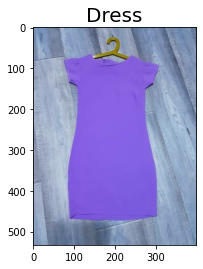

In [ ]:
# visualize a smaple of each class from the dataset 
train_img = glob(train_dir+'/dress/*.jpg') 

dress = np.asarray(cv.imread(train_img[0]))

plt.title('Dress', fontsize=20)
plt.imshow(dress)
print(dress.shape) # print image size

In [ ]:
class_names = []
for i in glob(train_dir+"/*"):
  class_names.append(i.split('/')[-1])

img_list = []
for i in range(len(class_names)):
  img_list.append(glob(train_dir+'/'+class_names[i]+'/*.jpg')[0])

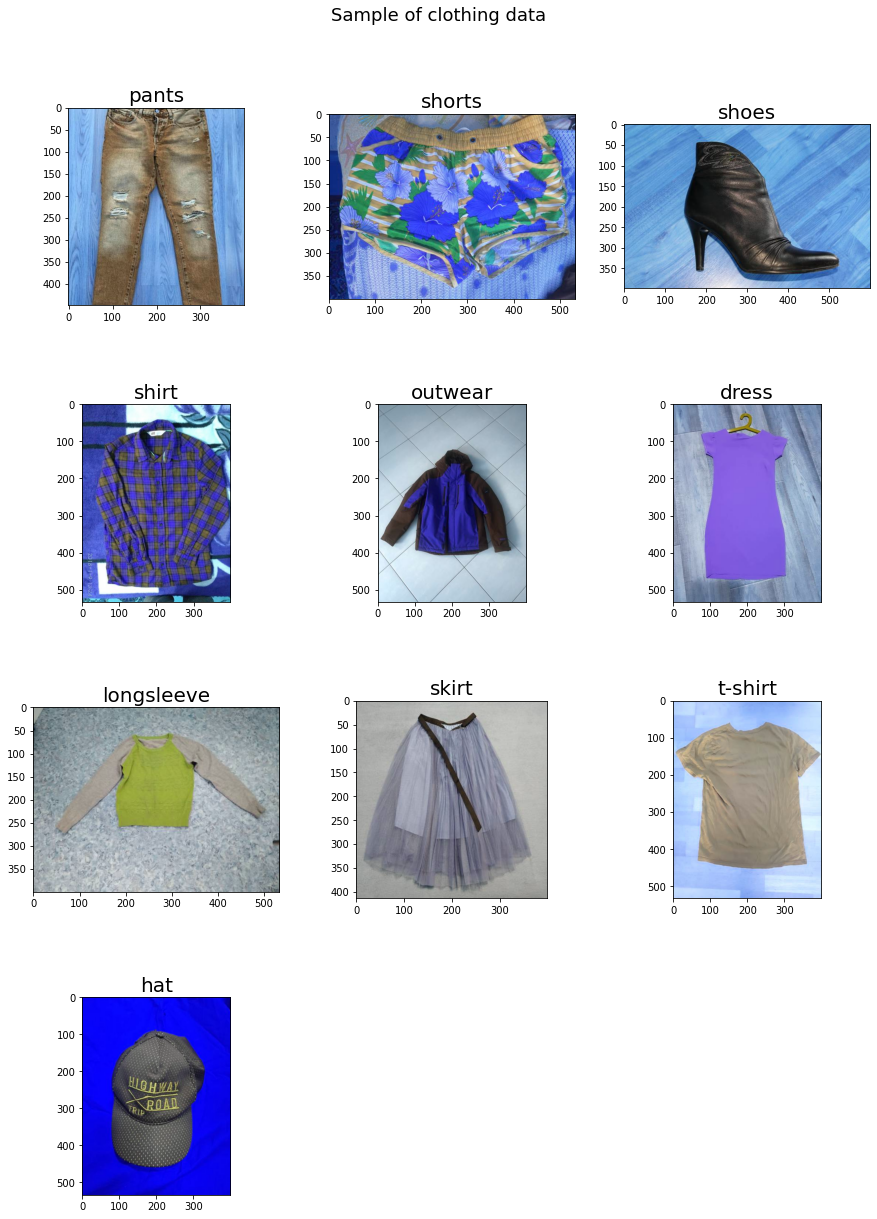

In [ ]:
plt.figure(figsize=(15, 20))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Sample of clothing data", fontsize=18, y=0.95)

for n, img in enumerate(img_list):
  plt.subplot(4, 3, n+1)
  class_name = class_names[n]
  image = np.asarray(cv.imread(img))
  plt.title(class_name, fontsize=20)
  plt.imshow(image)


Now we will check the distribution of our classes to see if there is any class imbalance

In [ ]:
freq = []
for i in range(len(class_names)):
  #print(np.shape(glob(train_dir+'/'+class_names[i]+'/*.jpg')))
  freq.append(len(glob(train_dir+'/'+class_names[i]+'/*.jpg')))

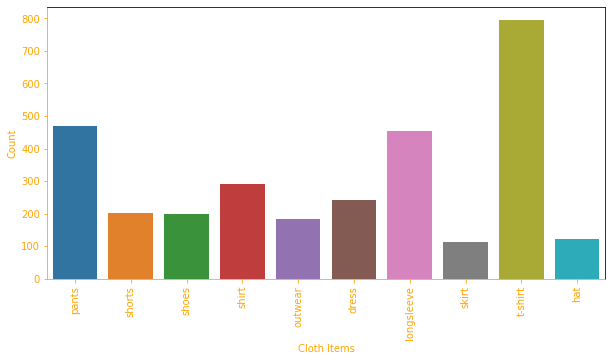

In [ ]:
plt.figure(figsize=(10, 5))
ax = sn.barplot(x=class_names, y=freq)

plt.xticks(rotation = 90);
ax.set_xlabel('Cloth Items')
ax.set_ylabel('Count')
ax.xaxis.label.set_color('Orange')        #setting up X-axis label color to yellow
ax.yaxis.label.set_color('Orange')          #setting up Y-axis label color to blue
ax.spines['left'].set_color('orange')        # setting up Y-axis tick color to red
ax.spines['bottom'].set_color('orange')         #setting up above X-axis tick color to red
ax.tick_params(axis='x', colors='orange')    #setting up X-axis tick color to red
ax.tick_params(axis='y', colors='orange')  #setting up Y-axis tick color to black
plt.show()

As observed from the above cell there is a slight imbalance in some of the classes like (tshirt, pants, and longsleeve), so we should keep that in mind, and fix it before training.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# Add some data augmentation to avoid overfitting
datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=30,
                             zoom_range=0.15)

val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
IMG_SIZE = (256,256)
batch_size=32

train_set = datagen.flow_from_directory(train_dir,
                                        subset='training',
                                        class_mode='categorical',
                                        batch_size=batch_size,
                                        target_size=IMG_SIZE,
                                        shuffle=True)

Found 3068 images belonging to 10 classes.


In [ ]:
valid_set = val_datagen.flow_from_directory(valid_dir,
                                       class_mode='categorical',
                                       subset='training',
                                       batch_size=batch_size,
                                       target_size=IMG_SIZE,
                                       shuffle=True)

test_set = val_datagen.flow_from_directory(test_dir,
                                       class_mode='categorical',
                                       subset='training',
                                       batch_size=372,
                                       target_size=IMG_SIZE,
                                       shuffle=True)

Found 341 images belonging to 10 classes.
Found 372 images belonging to 10 classes.


As observed from the above cells.
We have **3068** training sample, **341** validation sample, **372** testing sample


In [ ]:
X_train, y_train = train_set.next()
X_valid, y_valid = valid_set.next()
X_test, y_test = test_set.next()

print('Train X=%s Y=%s' %(X_train.shape, y_train.shape))
print('Validation X=%s Y=%s' %(X_valid.shape, y_valid.shape))
print('Test X=%s Y=%s' %(X_test.shape, y_test.shape))

Train X=(32, 256, 256, 3) Y=(32, 10)
Validation X=(32, 256, 256, 3) Y=(32, 10)
Test X=(372, 256, 256, 3) Y=(372, 10)


All of our images have been normalized and resized into 256,256,3 

First we will build a CNN model from scratch and test the model's performance

Keeping in mind that this model is going into production, I will try to keep the parameters as minimal as possible

In [ ]:
shape = (256, 256, 3)

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization
from keras.models import Sequential

model = Sequential()

model.add(Conv2D(filters=16, kernel_size=2, activation='relu', input_shape=shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, activation='relu', kernel_size=2))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))

model.add(Conv2D(filters=64, activation='relu', kernel_size=2))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))

model.add(Conv2D(filters=128, activation='relu', kernel_size=2))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))



model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 255, 255, 16)      208       
                                                                 
 batch_normalization (BatchN  (None, 255, 255, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 32)      2080      
                                                                 
 batch_normalization_1 (Batc  (None, 126, 126, 32)     1

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Apply early stopping and learning rate reduction to avoid overfitting 
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

checkpointer = ModelCheckpoint(filepath='clothing_CNN_model.hdf5', verbose=1, save_best_only=True)
reduce_learning_rate = ReduceLROnPlateau(monitor='val_accuracy',
                                        patience=2,
                                        verbose=1,
                                        factor=0.5,
                                        min_lr=0.00001)
early = EarlyStopping(monitor='val_loss',
                      patience=3,
                      restore_best_weights=True,
                      verbose=1)

In [ ]:
# Fix class imbalance problem
from collections import Counter
from sklearn.utils import class_weight

counter = Counter(train_set.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}  
class_weights

{0: 3.2987551867219915,
 1: 6.463414634146342,
 2: 1.7472527472527473,
 3: 4.320652173913044,
 4: 1.6987179487179487,
 5: 2.7413793103448274,
 6: 4.015151515151516,
 7: 3.9356435643564356,
 8: 7.098214285714286,
 9: 1.0}

In [ ]:
hist = model.fit(train_set, class_weight=class_weights, epochs=50, validation_data=valid_set, callbacks=[checkpointer,reduce_learning_rate,early], verbose=1)

Epoch 1/50
96/96 [==============================] - ETA: 0s - loss: 11.6148 - accuracy: 0.2024
Epoch 1: val_loss improved from inf to 6.76585, saving model to clothing_CNN_model.hdf5
96/96 [==============================] - 58s 509ms/step - loss: 11.6148 - accuracy: 0.2024 - val_loss: 6.7658 - val_accuracy: 0.1584 - lr: 0.0010
Epoch 2/50
96/96 [==============================] - ETA: 0s - loss: 5.4080 - accuracy: 0.2357
Epoch 2: val_loss improved from 6.76585 to 2.80741, saving model to clothing_CNN_model.hdf5
96/96 [==============================] - 51s 530ms/step - loss: 5.4080 - accuracy: 0.2357 - val_loss: 2.8074 - val_accuracy: 0.1965 - lr: 0.0010
Epoch 3/50
96/96 [==============================] - ETA: 0s - loss: 5.3104 - accuracy: 0.2435
Epoch 3: val_loss did not improve from 2.80741
96/96 [==============================] - 49s 513ms/step - loss: 5.3104 - accuracy: 0.2435 - val_loss: 4.1108 - val_accuracy: 0.1672 - lr: 0.0010
Epoch 4/50
96/96 [==============================] - ET

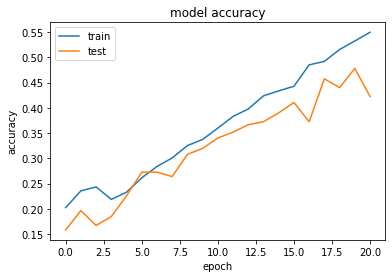

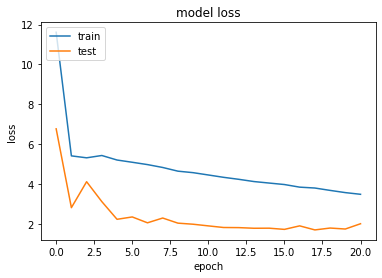

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
X_test, y_test = test_set.next()

pred=model.predict(test_set, verbose=1)

1/1 [==============================] - 3s 3s/step


In [ ]:
predicted_class_indices=np.argmax(pred,axis=1)

labels = (train_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
y_predict = [labels[k] for k in predicted_class_indices]

In [ ]:
predicted_class_indices=np.argmax(y_test,axis=1)

labels = (train_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
y_test = [labels[k] for k in predicted_class_indices]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_predict, target_names=class_names))

              precision    recall  f1-score   support

       pants       0.44      0.47      0.45        15
      shorts       0.12      0.25      0.17        12
       shoes       0.35      0.22      0.27        72
       shirt       0.18      0.16      0.17        38
     outwear       0.77      0.88      0.82        42
       dress       0.18      0.35      0.24        26
  longsleeve       0.74      0.27      0.40        73
       skirt       0.31      0.73      0.44        30
     t-shirt       0.07      0.17      0.10        12
         hat       0.86      0.46      0.60        52

    accuracy                           0.39       372
   macro avg       0.40      0.40      0.37       372
weighted avg       0.50      0.39      0.40       372



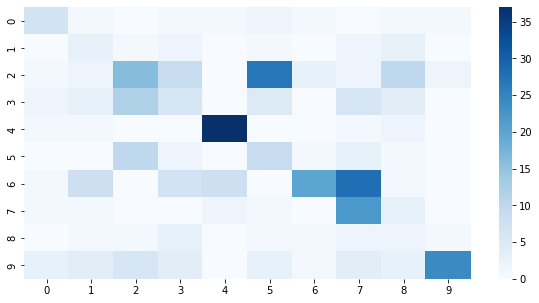

In [ ]:
cm = confusion_matrix(y_test, y_predict)

plt.figure(figsize=(10, 5))
sn.heatmap(cm, cmap='Blues')

# Now we will try using a pretrained model and fine tunning the parameters

I made sure to choose a model with fewer number of parameters since model size is of the essence

mobilenet comes as models with fixed image shape, and our (256,256,3) image is not in the predefined shapes in mobilenet. The closest shape is (224,224), thats why we got the below warning message

In [ ]:
import tensorflow as tf

mobilenet_model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=(256, 256, 3))

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
#Not to train the entire model
for layer in mobilenet_model.layers:
  layer.trainable=False

In [ ]:
#Add last fully connected layers

x = Flatten()(mobilenet_model.output)
prediction = Dense(10,activation='softmax')(x)

In [ ]:
from keras.models import Model
mobilenet_model = Model(inputs=mobilenet_model.input, outputs=prediction)

In [ ]:
mobilenet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 128, 128, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [ ]:
mobilenet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Apply early stopping and learning rate reduction to avoid overfitting 
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

checkpointer = ModelCheckpoint(filepath='clothing_mobilenet_model.hdf5', verbose=1, save_best_only=True)
reduce_learning_rate = ReduceLROnPlateau(monitor='val_accuracy',
                                        patience=2,
                                        verbose=1,
                                        factor=0.5,
                                        min_lr=0.00001)
early = EarlyStopping(monitor='val_loss',
                      patience=3,
                      restore_best_weights=True,
                      verbose=1)


In [ ]:

# Fix class imbalance problem
from collections import Counter
from sklearn.utils import class_weight

counter = Counter(train_set.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}  
class_weights

{0: 3.2987551867219915,
 1: 6.463414634146342,
 2: 1.7472527472527473,
 3: 4.320652173913044,
 4: 1.6987179487179487,
 5: 2.7413793103448274,
 6: 4.015151515151516,
 7: 3.9356435643564356,
 8: 7.098214285714286,
 9: 1.0}

In [ ]:
hist = mobilenet_model.fit(train_set, class_weight=class_weights, epochs=50, validation_data=valid_set, callbacks=[checkpointer,reduce_learning_rate,early], verbose=1)

Epoch 1/50
96/96 [==============================] - ETA: 0s - loss: 11.8969 - accuracy: 0.6734
Epoch 1: val_loss improved from inf to 1.47090, saving model to clothing_mobilenet_model.hdf5
96/96 [==============================] - 56s 554ms/step - loss: 11.8969 - accuracy: 0.6734 - val_loss: 1.4709 - val_accuracy: 0.8592 - lr: 0.0010
Epoch 2/50
96/96 [==============================] - ETA: 0s - loss: 3.9717 - accuracy: 0.8475
Epoch 2: val_loss did not improve from 1.47090
96/96 [==============================] - 53s 549ms/step - loss: 3.9717 - accuracy: 0.8475 - val_loss: 2.3081 - val_accuracy: 0.8270 - lr: 0.0010
Epoch 3/50
96/96 [==============================] - ETA: 0s - loss: 3.9716 - accuracy: 0.8680
Epoch 3: val_loss did not improve from 1.47090

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
96/96 [==============================] - 51s 535ms/step - loss: 3.9716 - accuracy: 0.8680 - val_loss: 2.8990 - val_accuracy: 0.8328 - lr: 0.0010
Epoch 4/50
96/96

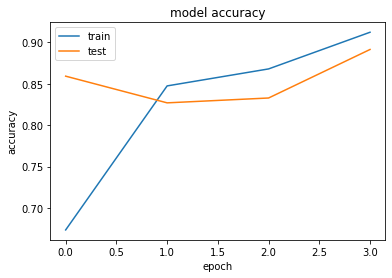

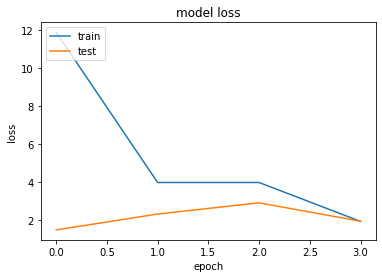

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
X_test, y_test = test_set.next()

pred=mobilenet_model.predict(test_set, verbose=1)

1/1 [==============================] - 6s 6s/step


In [ ]:
predicted_class_indices=np.argmax(pred,axis=1)

labels = (train_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
y_predict = [labels[k] for k in predicted_class_indices]

In [ ]:
predicted_class_indices=np.argmax(y_test,axis=1)

labels = (train_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
y_test = [labels[k] for k in predicted_class_indices]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_predict, target_names=class_names))

              precision    recall  f1-score   support

       pants       0.62      1.00      0.77        15
      shorts       0.85      0.92      0.88        12
       shoes       0.75      0.82      0.78        72
       shirt       0.89      0.66      0.76        38
     outwear       0.93      1.00      0.97        42
       dress       0.55      0.46      0.50        26
  longsleeve       1.00      0.97      0.99        73
       skirt       1.00      0.87      0.93        30
     t-shirt       1.00      0.75      0.86        12
         hat       0.85      0.90      0.88        52

    accuracy                           0.85       372
   macro avg       0.84      0.83      0.83       372
weighted avg       0.86      0.85      0.85       372



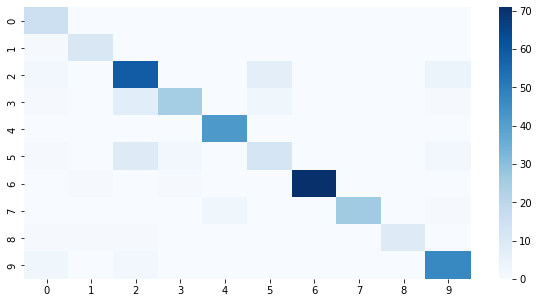

In [ ]:
cm = confusion_matrix(y_test, y_predict)

plt.figure(figsize=(10, 5))
sn.heatmap(cm, cmap='Blues')

The imporvments can be observed from the first glance. The test accuracy went from **39%** with our first model to **83%** with our mobilenet model 